In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **DATA HANDLING**

In [3]:
import tensorflow as tf
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
full_doc_path  = '/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/all.filt.txt'

In [3]:
## Function definitions

def letandspace(variable):
  return str.isalpha(variable) or variable == ' ' or str.isnumeric(variable)

def filtertxt(newsgroup):
  read_doc_path = f'/content/drive/Shareddrives/CSC591FinalProj/EncodedTextFiles/{newsgroup}.txt'
  write_doc_path = f'/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/{newsgroup}.filt.txt'

  ## Read document and convert to lowercase
  read_doc = open(read_doc_path, "r")
  data = read_doc.read().lower()
  read_doc.close()

  ## Create a list and remove header
  list_doc = data.split('\n')
  list_doc = [x for x in list_doc if not x.startswith('newsgroup:')]
  list_doc = [x for x in list_doc if not x.startswith('from:')]
  list_doc = [x for x in list_doc if not x.startswith('subject:')]
  list_doc = [x for x in list_doc if not x.startswith('in article')]
  rem_head = ' '.join(list_doc)

  ## Filter out data to alphanumeric and replace numbers with zeros
  filt_data = rem_head
  num_rem = ['1','2','3','4','5','6','7','8','9']
  filt_data = ''.join(filter(letandspace, filt_data))
  for char in num_rem:
    filt_data = filt_data.replace(char, '0')

  ## Remove document id number
  id_len = 7
  id_zer = '0'*id_len
  for i in range(id_len):
    filt_data = filt_data.replace(f'documentid {id_zer}','\n')
    id_zer = id_zer[:-1]
  with open(write_doc_path, "w") as text_file:
    text_file.write(filt_data)
  return filt_data

def create_vocab(txt_file_path):
  full_doc = open(txt_file_path, 'r')
  vector_words = CountVectorizer()
  full_vec = vector_words.fit_transform(full_doc)
  full_doc.close
  return vector_words

def vectorize_txt(txt_file_path, full_vocab):
  cur_doc = open(txt_file_path, "r")
  cur_vec = full_vocab.transform(cur_doc)
  cur_doc.close()
  return cur_vec.toarray().astype('uint8')[1:,:]

In [4]:
newsgroup_list = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
                  'comp.sys.mac.hardware','comp.windows.x','misc.forsale','rec.autos','rec.motorcycles',
                  'rec.sport.baseball','rec.sport.hockey','sci.crypt','sci.electronics','sci.med',
                  'sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast',
                  'talk.politics.misc','talk.religion.misc']
# newsgroup_list = ['sci.crypt','sci.space']

STOP. NO NEED TO RUN THE BELOW CELL. I HAVE ALREADY GENERATED THE FILTERED TEXT FILES

In [ ]:
## Filter Text
filt_start_time = time.time()
full_data = ''
for i in range(len(newsgroup_list)):
  cur_data = filtertxt(newsgroup_list[i])
  full_data = full_data + '\n' + cur_data
with open(full_doc_path, "w") as text_file:
  text_file.write(full_data)

filt_time = time.time()-filt_start_time
print(f"{math.floor(filt_time/60)} minutes, {filt_time % 60} seconds")

0 minutes, 37.562246322631836 seconds


CONTINUE RUNNING FROM THE BELOW CELL

In [5]:
## Vectorizing the files

vect_start_time = time.time()
full_vocab = create_vocab(full_doc_path)
for i in range(len(newsgroup_list)):
  print(f'Vectorizing {newsgroup_list[i]}')
  cur_path = f'/content/drive/Shareddrives/CSC591FinalProj/FilteredTextFiles/{newsgroup_list[i]}.filt.txt'
  cur_vec = vectorize_txt(cur_path,full_vocab)
  cur_lab = np.ones(cur_vec.shape[0])*i
  cur_len = len(cur_lab)
  half_len = int(cur_len/2)
  cur_vec = cur_vec[:half_len,:] # For some reason, there are exactly 2 copies of every document, so this removes the second half
  cur_lab = cur_lab[:half_len]
  if i == 0:
    full_vec = cur_vec
    full_lab = cur_lab
  else:
    full_vec = np.concatenate((full_vec,cur_vec),axis = 0)
    full_lab = np.concatenate((full_lab,cur_lab))
  # DO NOT UNCOMMENT BELOW. IF YOU DO, IT WILL TRY TO SAVE THE MATRICES AS CSV WHICH TAKES SEVERAL GB
  # np.savetxt(f'/content/drive/Shareddrives/CSC591FinalProj/BinaryMatrices/{newsgroup_list[i]}.csv', cur_vec, delimiter=",")

vect_time = time.time()-vect_start_time
print(f"{math.floor(vect_time/60)} minutes, {vect_time % 60} seconds")

Vectorizing alt.atheism
Vectorizing comp.graphics
Vectorizing comp.os.ms-windows.misc
Vectorizing comp.sys.ibm.pc.hardware
Vectorizing comp.sys.mac.hardware
Vectorizing comp.windows.x
Vectorizing misc.forsale
Vectorizing rec.autos
Vectorizing rec.motorcycles
Vectorizing rec.sport.baseball
Vectorizing rec.sport.hockey
Vectorizing sci.crypt
Vectorizing sci.electronics
Vectorizing sci.med
Vectorizing sci.space
Vectorizing soc.religion.christian
Vectorizing talk.politics.guns
Vectorizing talk.politics.mideast
Vectorizing talk.politics.misc
Vectorizing talk.religion.misc
1 minutes, 9.073071718215942 seconds


In [6]:
# Count every word
counts = np.sum(full_vec,axis = 0)

In [7]:
# Remove uncommon words
freq_thr = 50 # Frequency threshold; I added this to get rid of words that were very uncommon, 50 works well.
cnt_thr = counts > freq_thr
print(f'Full Vocab Length: {full_vec.shape[1]}')
print(f'Trimmed Vocab Length: {sum(cnt_thr)}')
trm_vec = full_vec[:,cnt_thr]

wpd = np.sum(trm_vec,axis = 1)   #words per doc
trm_vec = trm_vec[wpd>0,:]
short_wpd = wpd[wpd>0]
trm_counts = np.sum(trm_vec, axis = 0)
norm_len = 100
trm_vec = trm_vec/short_wpd[:,None]*100 # Normalize the length of the documents as per the EM reference suggestion
trm_lab = full_lab[wpd>0]
trm_word_ind = np.array(range(len(cnt_thr)))[cnt_thr]

Full Vocab Length: 152246
Trimmed Vocab Length: 6589


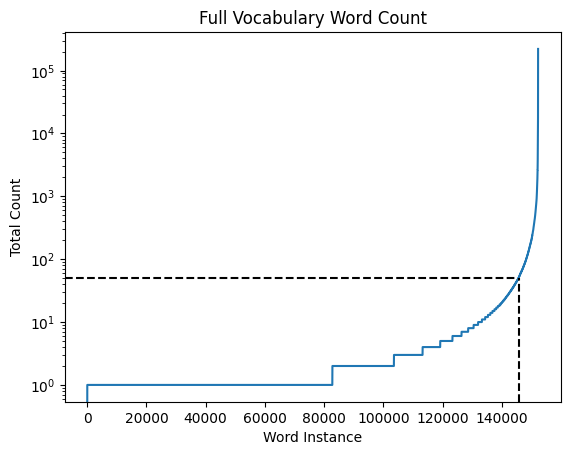

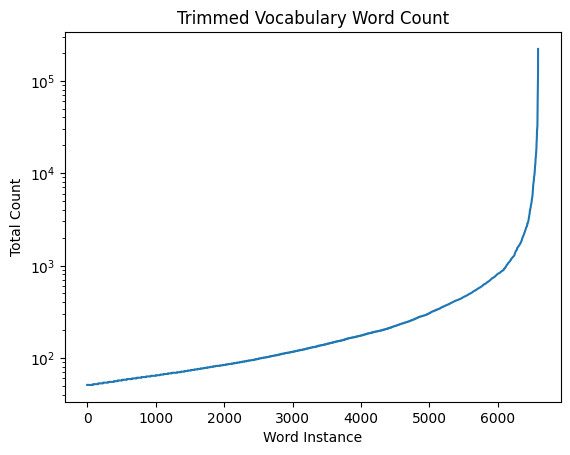

In [8]:
## Plot word distribution

word_thr = full_vec.shape[1]-sum(cnt_thr)
sort_full_counts = np.sort(counts)
sort_trm_counts = np.sort(trm_counts)
plt.plot(sort_full_counts)
plt.axhline(y = freq_thr, xmax = 0.91, color = 'k', linestyle = '--')
plt.axvline(x = word_thr, ymax = 0.335, color = 'k', linestyle = '--')
plt.yscale('log')
plt.xlabel('Word Instance')
plt.ylabel('Total Count')
plt.title('Full Vocabulary Word Count')
plt.show()
plt.plot(sort_trm_counts)
plt.yscale('log')
plt.xlabel('Word Instance')
plt.ylabel('Total Count')
plt.title('Trimmed Vocabulary Word Count')
plt.show()


In [9]:
## Print top words
sort_args = np.flip(np.argsort(counts))
my_dict = full_vocab.vocabulary_
common_words = ''
for i in range(20):
  if i == 0:
    common_words = list(my_dict.keys())[list(my_dict.values()).index(sort_args[i])]
  else:
    common_words = common_words + ', ' + list(my_dict.keys())[list(my_dict.values()).index(sort_args[i])]
print(common_words)

the, to, of, and, in, is, that, it, for, you, this, on, 00, be, have, not, are, with, as, or


In [10]:
# Split data into training and test
## WE CAN ONLY HAVE A TOTAL OF 626 DOCUMENTS PER CLASS (THE FINAL NEWSGROUP ONLY HAS 626 DOCUMENTS TOTAL)
lab_per_class = 50 # labeled train data per class
unlab_per_class = 400 # unlabeled train data per class
train_per_class = lab_per_class + unlab_per_class # train data per class
test_per_class = 100
total_lab = lab_per_class*20
total_unlab = unlab_per_class*20
total_test = test_per_class*20
for i in range(20):
  temp_data = trm_vec[trm_lab == i,:]
  arts = temp_data.shape[0]
  temp_ord = np.random.permutation(arts)
  temp_data = temp_data[temp_ord,:]
  temp_ltrain_data = temp_data[:lab_per_class,:]
  temp_unltrain_data = temp_data[lab_per_class:train_per_class,:]
  temp_test_data = temp_data[-test_per_class:,:]
  temp_ltrain_lab = np.ones(lab_per_class)*i
  temp_unltrain_lab = np.ones(unlab_per_class)*i
  temp_test_lab = np.ones(test_per_class)*i
  if i == 0:
    ltrain_lab = temp_ltrain_lab
    unltrain_lab = temp_unltrain_lab
    test_lab = temp_test_lab
    ltrain_data = temp_ltrain_data
    unltrain_data = temp_unltrain_data
    test_data = temp_test_data
  else:
    ltrain_lab = np.concatenate((ltrain_lab,temp_ltrain_lab))
    unltrain_lab = np.concatenate((unltrain_lab,temp_unltrain_lab))
    test_lab = np.concatenate((test_lab,temp_test_lab))
    ltrain_data = np.concatenate((ltrain_data,temp_ltrain_data))
    unltrain_data = np.concatenate((unltrain_data,temp_unltrain_data))
    test_data = np.concatenate((test_data,temp_test_data))
print('Labeled Training Data Size')
print(ltrain_data.shape)
print('Unlabeled Training Data Size')
print(unltrain_data.shape)
print('Testing Data Size')
print(test_data.shape)

Labeled Training Data Size
(1000, 6589)
Unlabeled Training Data Size
(8000, 6589)
Testing Data Size
(2000, 6589)


THIS IS THE END OF THE DATA HANDLING. EVERYTHING BELOW IS FOR MY CLASSIFIER

# **EM NB CLASSIFIER**

In [11]:
# Define necessary functions
def compute_p_lab(data,lab):  #for labeled data. For unlabeled data, use pred_unltrain
  p_lab = np.zeros((len(lab),20))
  for i in range(len(lab)):
    p_lab[i,int(lab[i])] = 1
  return p_lab

def compute_p_w_c(data,p_lab,lam):
  voc_len = data.shape[1]
  p_w_c = np.zeros((20,voc_len))
  lam_vec = np.ones(p_lab.shape[0])*lam
  lam_vec[:total_lab] = 1
  for i in range(20):
    for j in range(voc_len):
      p_w_c[i,j] = np.dot(p_lab[:,i]*lam_vec,data[:,j])
  p_w_c_sum = np.sum(p_w_c, axis = 1)
  p_w_c = (1+p_w_c)/(voc_len+p_w_c_sum[:,None])
  return p_w_c

def compute_p_c(p_lab,lam):
  lam_vec = np.ones(p_lab.shape[0])*lam
  lam_vec[:total_lab] = 1
  p_c = (1+np.sum(p_lab*lam_vec[:,None],axis = 0))/(20+sum(lam_vec[:p_lab.shape[0]]))
  return p_c

In [12]:
# Train Initial NB Classifier
lam = 1 #lambda for weighting unlabeled data; 1 appeared best for us, 0 is the same as supervised NB
p_lab = compute_p_lab(ltrain_data,ltrain_lab)
p_w_c = compute_p_w_c(ltrain_data,p_lab,lam)
p_c = compute_p_c(p_lab,lam)
print(p_lab)
print(p_w_c)
print(p_c)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[8.42002956e-04 2.13010106e-04 3.06495958e-04 ... 8.62887221e-05
  8.62887221e-05 8.62887221e-05]
 [4.39092498e-03 1.82554915e-03 2.84048485e-03 ... 8.62887221e-05
  8.62887221e-05 8.62887221e-05]
 [5.40351585e-03 1.36652828e-03 4.49696906e-04 ... 8.62887221e-05
  8.62887221e-05 8.62887221e-05]
 ...
 [1.85010379e-03 4.92853476e-04 2.49824819e-03 ... 8.62887221e-05
  8.62887221e-05 8.62887221e-05]
 [3.55234918e-03 2.22555578e-03 3.88082625e-03 ... 8.62887221e-05
  8.62887221e-05 8.62887221e-05]
 [4.69090718e-04 2.08420064e-03 1.14950909e-03 ... 8.62887221e-05
  8.62887221e-05 8.62887221e-05]]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]


In [13]:
## define prediction using classifier
def nb_classify(data,p_w_c,p_c):
  pred_lab = np.ones((data.shape[0],20))
  for i in range(len(pred_lab)):
    cur_doc = data[i,:]
    for k in range(20):
      pred_lab[i,k] = np.product(np.power(10*p_w_c[k,:],cur_doc))
    pred_lab[i,:] = pred_lab[i,:]*p_c
    if sum(pred_lab[i,:])>0:
      pred_lab[i,:] = pred_lab[i,:]/sum(pred_lab[i,:])
  return pred_lab

In [14]:
## Make predictions
pred_start = time.time()
pred_ltrain = nb_classify(ltrain_data,p_w_c,p_c)
pred_unltrain = nb_classify(unltrain_data,p_w_c,p_c)
pred_test = nb_classify(test_data,p_w_c,p_c)
print(f'{round(time.time()-pred_start)} seconds have passed')

39 seconds have passed


In [15]:
## Check accuracy of each data set
pred_ltrain_lab = np.argmax(pred_ltrain, axis = 1)
pred_unltrain_lab = np.argmax(pred_unltrain, axis = 1)
pred_test_lab = np.argmax(pred_test, axis = 1)
print(f'Intial NB Classifier Labeled Training Data Accuracy: {sum(pred_ltrain_lab == ltrain_lab)/total_lab}')
print(f'Intial NB Classifier Unlabeled Training Data Accuracy: {sum(pred_unltrain_lab == unltrain_lab)/total_unlab}')
print(f'Intial NB Classifier Test Data Accuracy: {sum(pred_test_lab == test_lab)/total_test}')

Intial NB Classifier Labeled Training Data Accuracy: 0.987
Intial NB Classifier Unlabeled Training Data Accuracy: 0.62275
Intial NB Classifier Test Data Accuracy: 0.627


In [ ]:
## EM
em_start = time.time()
dif = 1
iter = 0
pred_unltrain_new = pred_unltrain
old_test_acc = sum(pred_test_lab == test_lab)/total_test
while dif >= 0.001:
  iter += 1
  print(f'Iteration {iter}')
  # M Step
  p_lab_aug = np.concatenate((p_lab,pred_unltrain_new))
  data_aug = np.concatenate((ltrain_data,unltrain_data))
  p_w_c_new = compute_p_w_c(data_aug,p_lab_aug,lam)
  p_c_new = compute_p_c(p_lab_aug,lam)
  # E Step
  pred_ltrain_new = nb_classify(ltrain_data,p_w_c_new,p_c_new)
  pred_unltrain_new = nb_classify(unltrain_data,p_w_c_new,p_c_new)
  pred_test_new = nb_classify(test_data,p_w_c_new,p_c_new)
  pred_ltrain_lab_new = np.argmax(pred_ltrain_new, axis = 1)
  pred_unltrain_lab_new = np.argmax(pred_unltrain_new, axis = 1)
  pred_test_lab_new = np.argmax(pred_test_new, axis = 1)
  print(f'Current NB Classifier Labeled Training Data Accuracy: {sum(pred_ltrain_lab_new == ltrain_lab)/total_lab}')
  print(f'Current NB Classifier Unlabeled Training Data Accuracy: {sum(pred_unltrain_lab_new == unltrain_lab)/total_unlab}')
  print(f'Current NB Classifier Test Data Accuracy: {sum(pred_test_lab_new == test_lab)/total_test}')
  print()
  new_test_acc = sum(pred_test_lab_new == test_lab)/total_test
  dif = new_test_acc-old_test_acc
  old_test_acc = new_test_acc
em_time = time.time()-em_start
print(f"EM Runtime: {math.floor(em_time/60)} minutes, {em_time % 60} seconds")

Iteration 1
Current NB Classifier Labeled Training Data Accuracy: 0.918
Current NB Classifier Unlabeled Training Data Accuracy: 0.665875
Current NB Classifier Test Data Accuracy: 0.672

Iteration 2
Current NB Classifier Labeled Training Data Accuracy: 0.893
Current NB Classifier Unlabeled Training Data Accuracy: 0.670875
Current NB Classifier Test Data Accuracy: 0.673

Iteration 3
Current NB Classifier Labeled Training Data Accuracy: 0.887
Current NB Classifier Unlabeled Training Data Accuracy: 0.67275
Current NB Classifier Test Data Accuracy: 0.672

EM Runtime: 2 minutes, 14.133804082870483 seconds


In [ ]:
# Find top words per class (not unique, so not very interesting)
top_word_per_class = np.flip(np.argsort(p_w_c,axis = 1))
k_words = 10
for j in range(20):
  top_args = trm_word_ind[top_word_per_class[j,0:k_words]]
  my_dict = full_vocab.vocabulary_
  top_words = ''
  for i in range(k_words):
    if i == 0:
      top_words = list(my_dict.keys())[list(my_dict.values()).index(top_args[i])]
    else:
      top_words = top_words + ', ' + list(my_dict.keys())[list(my_dict.values()).index(top_args[i])]
  print(top_words + '   ' + newsgroup_list[j])

they, one, all, with, what, but, by, an, or, was   alt.atheism
all, my, one, or, by, about, writes, they, what, your   comp.graphics
an, they, what, was, or, if, with, israeli, were, 0000   comp.os.ms-windows.misc
would, were, all, with, was, by, what, but, your, there   comp.sys.ibm.pc.hardware
have, he, but, if, or, by, all, on, about, my   comp.sys.mac.hardware
was, or, there, one, from, 0000, would, 00, with, are   comp.windows.x
you, on, about, any, but, if, at, as, one, with   misc.forsale
can, be, there, 0000, this, with, would, anyone, they, use   rec.autos
will, at, as, by, but, chip, all, can, just, what   rec.motorcycles
not, with, he, go, or, but, if, hockey, as, they   rec.sport.baseball
but, or, if, than, are, with, be, at, writes, year   rec.sport.hockey
writes, bike, if, dod, are, this, like, me, your, can   sci.crypt
was, with, about, 000, but, an, not, all, or, cars   sci.electronics
00000, me, manual, is, sell, but, box, if, condition, price   sci.med
does, if, not, 

In [ ]:
# Find most unique words per class
argmax_per_word = np.flip(np.argsort(p_w_c, axis = 0),axis = 0)
max_per_word = np.max(p_w_c,axis = 0)
second_max_per_word = p_w_c[argmax_per_word[1,:],np.array(range(len(argmax_per_word[1,:])))]
word_diff = max_per_word-second_max_per_word
unique_word_per_class = np.zeros(20)
for i in range(20):
  class_word_diff = word_diff*(argmax_per_word[0,:] == i)
  diff_ind = np.argmax(class_word_diff)
  unique_word_per_class[i] = int(diff_ind)
  print(diff_ind)
unique_word_per_class = unique_word_per_class.astype(int)

3197
2867
3833
1941
3494
6457
1
902
668
3602
2752
3207
5178
2706
5512
2519
2273
3088
3656
2384


In [ ]:
# Print unique words
unique_args = trm_word_ind[unique_word_per_class]
my_dict = full_vocab.vocabulary_
unique_words = ''
for i in range(20):
  if i == 0:
    unique_words = newsgroup_list[i] + ': ' + list(my_dict.keys())[list(my_dict.values()).index(unique_args[i])]
  else:
    unique_words = unique_words + '\n' + newsgroup_list[i] + ': ' + list(my_dict.keys())[list(my_dict.values()).index(unique_args[i])]
print(unique_words)

alt.atheism: keith
comp.graphics: image
comp.os.ms-windows.misc: mt
comp.sys.ibm.pc.hardware: email
comp.sys.mac.hardware: mac
comp.windows.x: window
misc.forsale: 000
rec.autos: car
rec.motorcycles: bike
rec.sport.baseball: mattingly
rec.sport.hockey: hockey
sci.crypt: key
sci.electronics: scope
sci.med: her
sci.space: space
soc.religion.christian: god
talk.politics.guns: firearms
talk.politics.mideast: israeli
talk.politics.misc: men
talk.religion.misc: freedom


In [ ]:
## Confusion Matrix for EM
conf_mat = np.zeros((20,20))
for i in range(20):
  cur_pred = pred_test_lab_new[i*test_per_class:(i+1)*test_per_class]
  for j in range(20):
    conf_mat[i,j] = sum(cur_pred == j)

In [ ]:
## Class by class metrics for EM
rec_per_class = np.zeros(20)
prec_per_class = np.zeros(20)
for i in range(20):
  rec_per_class[i] = conf_mat[i,i]/test_per_class
  prec_per_class[i] = conf_mat[i,i]/sum(conf_mat[:,i])

In [ ]:
## Save metrics (no need to run)
metrics_per_class = np.concatenate((rec_per_class[None,:],prec_per_class[None,:]))
print(metrics_per_class)
metrics_path = f'/content/drive/Shareddrives/CSC591FinalProj/Metrics/EM_{total_lab}_{total_unlab}_{total_test}_lam{lam}.csv'
np.savetxt(metrics_path, metrics_per_class, delimiter=",")

[[0.66       0.65       0.66       0.78       0.67       0.72
  0.73       0.8        0.86       0.83       0.9        0.76
  0.69       0.81       0.83       0.85       0.88       0.75
  0.51       0.25      ]
 [0.44295302 0.45774648 0.66666667 0.68421053 0.71276596 0.85714286
  0.83908046 0.82474227 0.76785714 0.91208791 0.91836735 0.8172043
  0.79310345 0.94186047 0.90217391 0.64393939 0.56774194 0.84269663
  0.80952381 0.69444444]]


In [5]:
## Grab SAT Results
SAT_lab_num = [200,1000,2000]
SAT_rec_mat = np.zeros((3,20))
SAT_prec_mat = np.zeros((3,20))
SAT_acc_mat = np.zeros(3)
for i in range(len(SAT_lab_num)):
  conf_mat_path = f'/content/drive/Shareddrives/CSC591FinalProj/export_{SAT_lab_num[i]}.csv'
  SAT_conf_mat = np.loadtxt(conf_mat_path, delimiter=",", dtype=float)
  SAT_acc_mat[i] = np.trace(SAT_conf_mat/2000)
  for j in range(20):
    SAT_rec_mat[i,j] = SAT_conf_mat[j,j]/100
    SAT_prec_mat[i,j] = SAT_conf_mat[j,j]/sum(SAT_conf_mat[:,j])

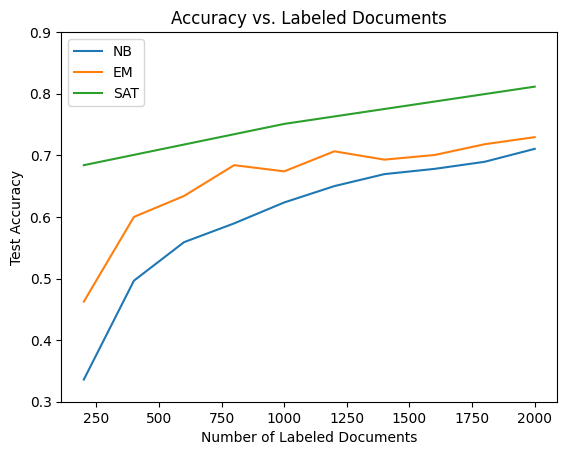

In [6]:
## Plot Accuracy vs Labeled Docs
lab_num_vec = [200,400,600,800,1000,1200,1400,1600,1800,2000]
em_test_acc_vec = [0.4625,0.6,0.634,0.684,0.674,0.7065,0.693,0.7005,0.718,0.7295] # Hardcoded from trials
nb_test_acc_vec = [0.336,0.4965,0.559,0.5895,0.6235,0.65,0.6695,0.678,0.6895,0.7105] # Hardcoded from trials
plt.plot(lab_num_vec,nb_test_acc_vec,label = 'NB')
plt.plot(lab_num_vec,em_test_acc_vec,label = 'EM')
plt.plot(SAT_lab_num,SAT_acc_mat, label = 'SAT')
plt.legend()
plt.ylim((0.3,0.9))
plt.title('Accuracy vs. Labeled Documents')
plt.xlabel('Number of Labeled Documents')
plt.ylabel('Test Accuracy')
plt.show()

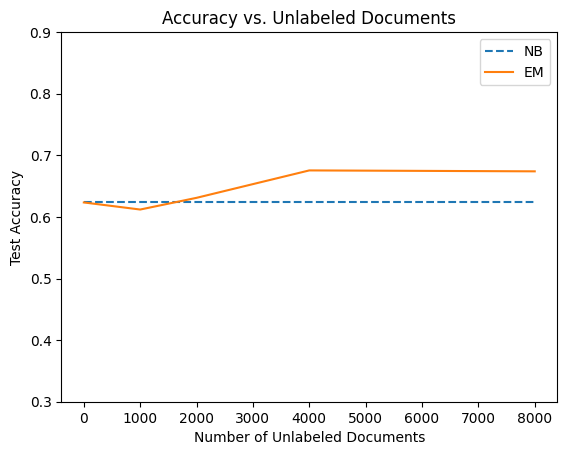

In [ ]:
## Plot Accuracy vs Unlabeled Docs
unlab_num_vec = [0,1000,2000,4000,8000]
em_test_acc_vec_unl = [0.6235,0.612,0.631,0.6755,0.674] # Hardcoded from trials
plt.hlines(em_test_acc_vec_unl[0], xmin = 0, xmax = 8000, linestyles = 'dashed',label = 'NB')
plt.plot(unlab_num_vec,em_test_acc_vec_unl,label = 'EM', color = '#ff7f0e')
plt.legend()
plt.title('Accuracy vs. Unlabeled Documents')
plt.xlabel('Number of Unlabeled Documents')
plt.ylim((0.3,0.9))
plt.ylabel('Test Accuracy')
plt.show()

In [13]:
## Combine class by class metrics for EM
all_lab_num = [200,1000,2000]
for i in range(len(all_lab_num)):
  cur_lab_num = all_lab_num[i]
  prec_rec_path = f'/content/drive/Shareddrives/CSC591FinalProj/Metrics/EM_{cur_lab_num}_8000_2000_lam1.csv'
  cur_met = np.loadtxt(prec_rec_path,
                 delimiter=",", dtype=float)
  cur_rec = cur_met[0,:][None,:]
  cur_prec = cur_met[1,:][None,:]
  if i == 0:
    total_rec = cur_rec
    total_prec = cur_prec
  else:
    total_rec = np.concatenate((total_rec,cur_rec))
    total_prec = np.concatenate((total_prec,cur_prec))
  display(cur_met)

array([[0.86      , 0.17      , 0.81      , 0.65      , 0.21      ,
        0.54      , 0.65      , 0.6       , 0.34      , 0.91      ,
        0.11      , 0.74      , 0.15      , 0.12      , 0.26      ,
        0.3       , 0.66      , 0.74      , 0.39      , 0.04      ],
       [0.25368732, 0.39534884, 0.31274131, 0.36723164, 0.58333333,
        0.75      , 0.74712644, 0.48      , 0.85      , 0.5       ,
        0.78571429, 0.77894737, 0.78947368, 0.92307692, 0.76470588,
        0.38961039, 0.57391304, 0.7184466 , 0.23636364, 0.8       ]])

array([[0.78      , 0.53      , 0.72      , 0.68      , 0.53      ,
        0.59      , 0.64      , 0.82      , 0.59      , 0.84      ,
        0.85      , 0.7       , 0.52      , 0.62      , 0.69      ,
        0.75      , 0.71      , 0.77      , 0.73      , 0.19      ],
       [0.46987952, 0.42741935, 0.52554745, 0.49275362, 0.6625    ,
        0.78666667, 0.77108434, 0.52564103, 0.9516129 , 0.86597938,
        0.94444444, 0.93333333, 0.65822785, 0.88571429, 0.85185185,
        0.6147541 , 0.67619048, 0.93902439, 0.47402597, 0.79166667]])

array([[0.66      , 0.65      , 0.66      , 0.78      , 0.67      ,
        0.72      , 0.73      , 0.8       , 0.86      , 0.83      ,
        0.9       , 0.76      , 0.69      , 0.81      , 0.83      ,
        0.85      , 0.88      , 0.75      , 0.51      , 0.25      ],
       [0.44295302, 0.45774648, 0.66666667, 0.68421053, 0.71276596,
        0.85714286, 0.83908046, 0.82474227, 0.76785714, 0.91208791,
        0.91836735, 0.8172043 , 0.79310345, 0.94186047, 0.90217391,
        0.64393939, 0.56774194, 0.84269663, 0.80952381, 0.69444444]])

In [16]:
## Confusion Matrix for NB
NB_conf_mat = np.zeros((20,20))
for i in range(20):
  cur_pred = pred_test_lab[i*test_per_class:(i+1)*test_per_class]
  for j in range(20):
    NB_conf_mat[i,j] = sum(cur_pred == j)

In [ ]:
# Save confusion matrix NB
NB_conf_path = f'/content/drive/Shareddrives/CSC591FinalProj/Metrics/NB_{total_lab}_{total_unlab}_{total_test}_lam{lam}_conf.csv'
np.savetxt(NB_conf_path, NB_conf_mat, delimiter=",")

In [11]:
# Load confusion matrix and compute performance metrics
NB_conf_mat = np.loadtxt(NB_conf_path,
                 delimiter=",", dtype=float)
np.trace(NB_conf_mat)
NB_rec = np.zeros(20)
NB_prec = np.zeros(20)
for i in range(20):
  NB_rec[i] = NB_conf_mat[i,i]/50
  NB_prec[i] = NB_conf_mat[i,i]/sum(NB_conf_mat[:,i])

In [14]:
# Compute F1
NB_f1 = 2*(NB_rec*NB_prec)/(NB_rec+NB_prec)
EM_f1 = 2*(total_rec*total_prec)/(total_rec+total_prec)
SAT_f1 = 2*(SAT_rec_mat*SAT_prec_mat)/(SAT_rec_mat+SAT_prec_mat)

# ALL PLOTTING BELOW HERE

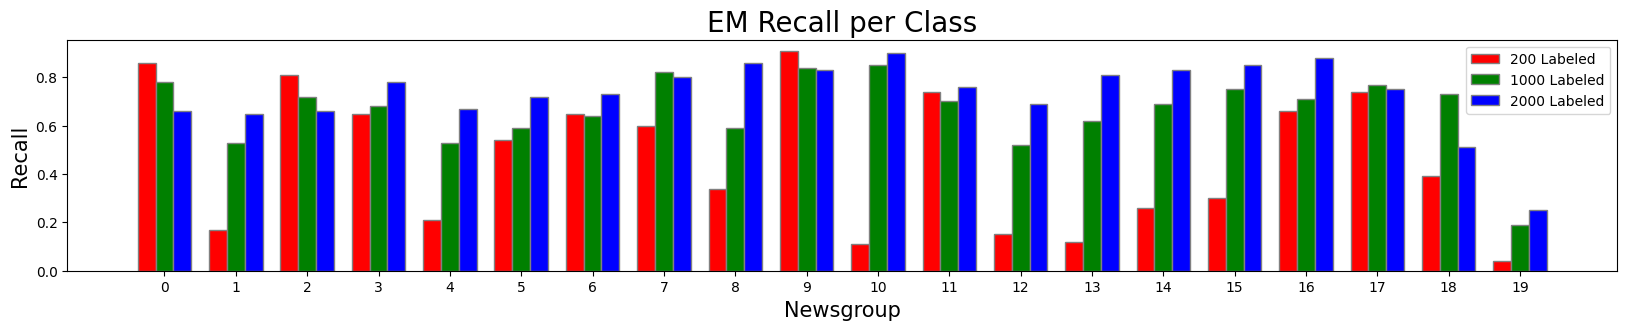

In [ ]:
## Plot Recall EM
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 3))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, total_rec[0,:], color ='r', width = barWidth,
        edgecolor ='grey', label ='200 Labeled')
plt.bar(br2, total_rec[1,:], color ='g', width = barWidth,
        edgecolor ='grey', label ='1000 Labeled')
plt.bar(br3, total_rec[2,:], color ='b', width = barWidth,
        edgecolor ='grey', label ='2000 Labeled')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('Recall', fontsize = 15)
plt.title('EM Recall per Class',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()

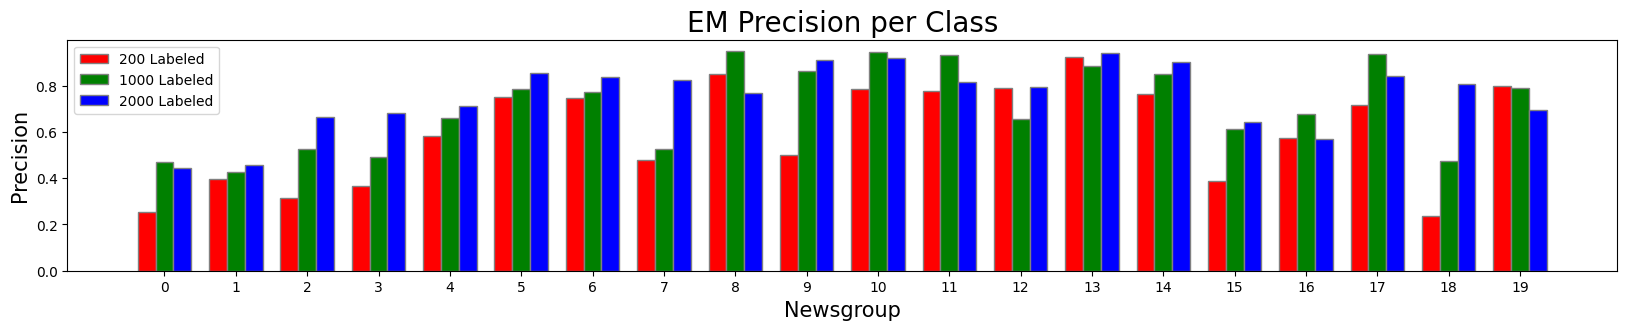

In [ ]:
## Plot Precision EM
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 3))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, total_prec[0,:], color ='r', width = barWidth,
        edgecolor ='grey', label ='200 Labeled')
plt.bar(br2, total_prec[1,:], color ='g', width = barWidth,
        edgecolor ='grey', label ='1000 Labeled')
plt.bar(br3, total_prec[2,:], color ='b', width = barWidth,
        edgecolor ='grey', label ='2000 Labeled')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.title('EM Precision per Class',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()

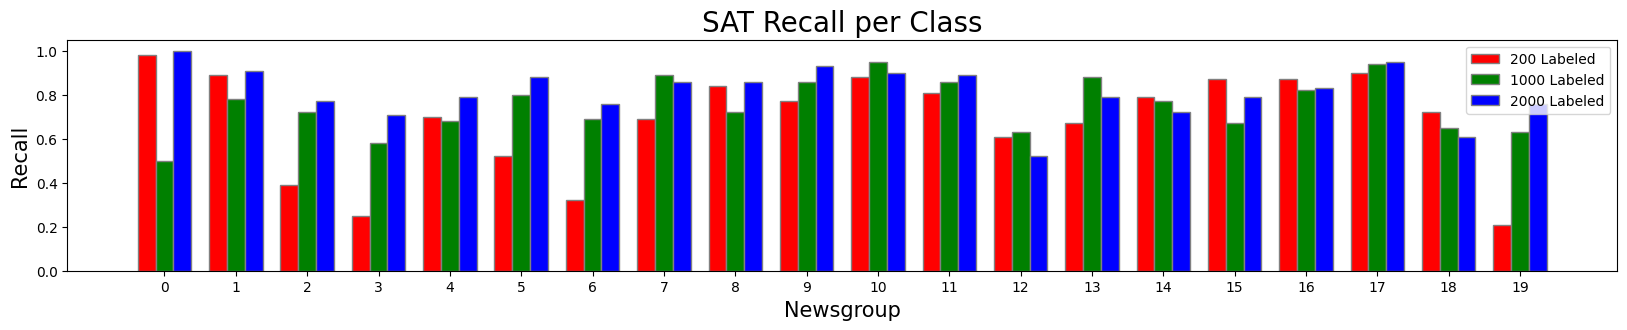

In [ ]:
## Plot Recall SAT
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 3))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, SAT_rec_mat[0,:], color ='r', width = barWidth,
        edgecolor ='grey', label ='200 Labeled')
plt.bar(br2, SAT_rec_mat[1,:], color ='g', width = barWidth,
        edgecolor ='grey', label ='1000 Labeled')
plt.bar(br3, SAT_rec_mat[2,:], color ='b', width = barWidth,
        edgecolor ='grey', label ='2000 Labeled')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('Recall', fontsize = 15)
plt.title('SAT Recall per Class',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()

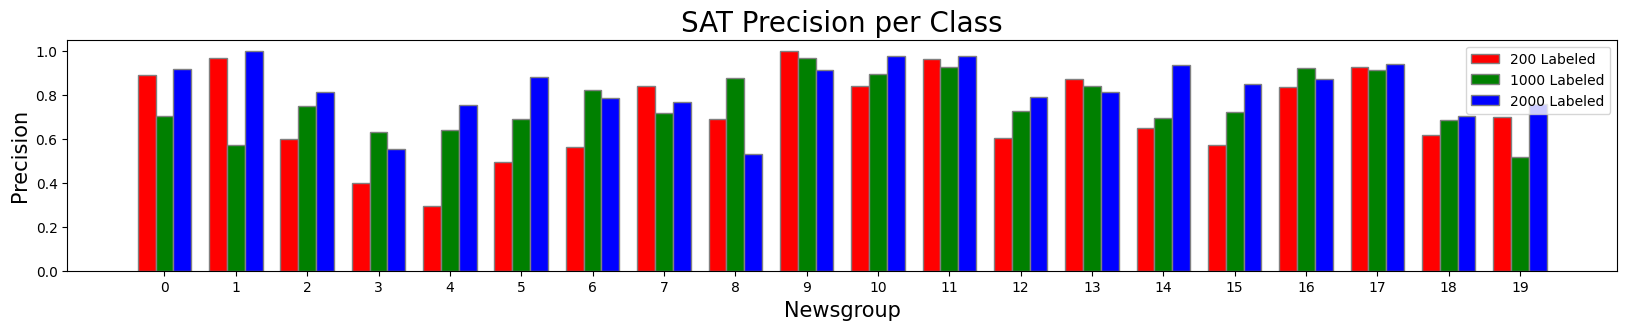

In [ ]:
## Plot Precision SAT
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 3))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, SAT_prec_mat[0,:], color ='r', width = barWidth,
        edgecolor ='grey', label ='200 Labeled')
plt.bar(br2, SAT_prec_mat[1,:], color ='g', width = barWidth,
        edgecolor ='grey', label ='1000 Labeled')
plt.bar(br3, SAT_prec_mat[2,:], color ='b', width = barWidth,
        edgecolor ='grey', label ='2000 Labeled')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.title('SAT Precision per Class',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()

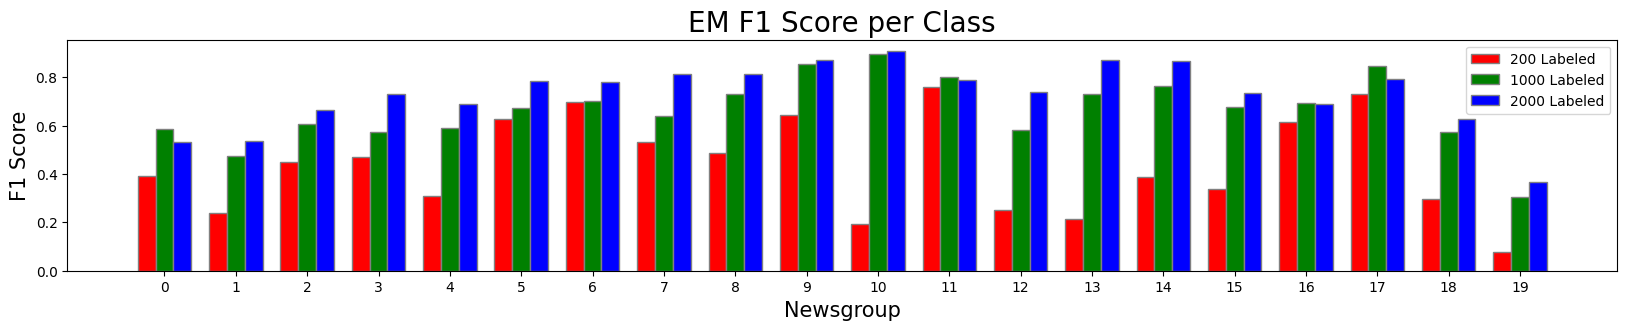

In [41]:
## Plot F1 EM
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 3))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, EM_f1[0,:], color ='r', width = barWidth,
        edgecolor ='grey', label ='200 Labeled')
plt.bar(br2, EM_f1[1,:], color ='g', width = barWidth,
        edgecolor ='grey', label ='1000 Labeled')
plt.bar(br3, EM_f1[2,:], color ='b', width = barWidth,
        edgecolor ='grey', label ='2000 Labeled')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('F1 Score', fontsize = 15)
plt.title('EM F1 Score per Class',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()

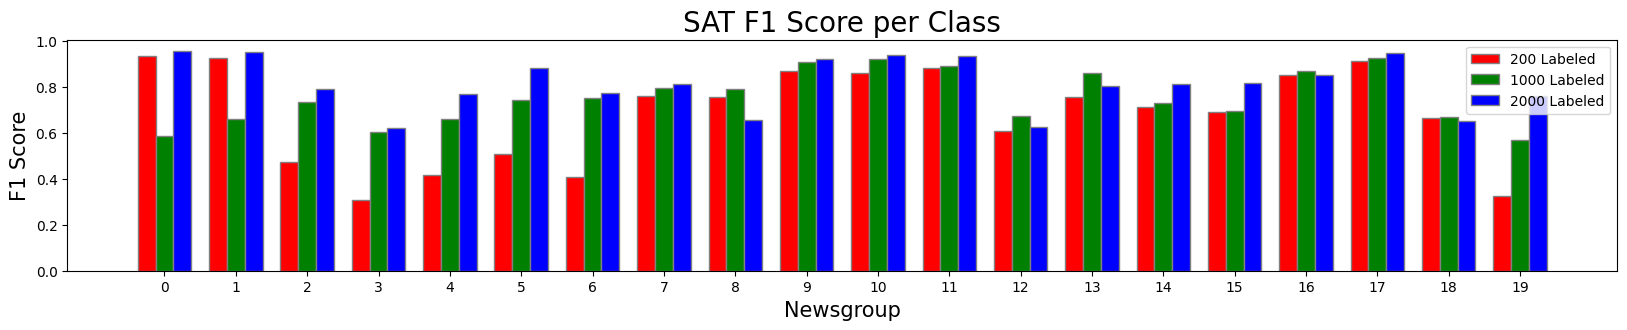

In [42]:
## Plot F1 SAT
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 3))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, SAT_f1[0,:], color ='r', width = barWidth,
        edgecolor ='grey', label ='200 Labeled')
plt.bar(br2, SAT_f1[1,:], color ='g', width = barWidth,
        edgecolor ='grey', label ='1000 Labeled')
plt.bar(br3, SAT_f1[2,:], color ='b', width = barWidth,
        edgecolor ='grey', label ='2000 Labeled')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('F1 Score', fontsize = 15)
plt.title('SAT F1 Score per Class',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()

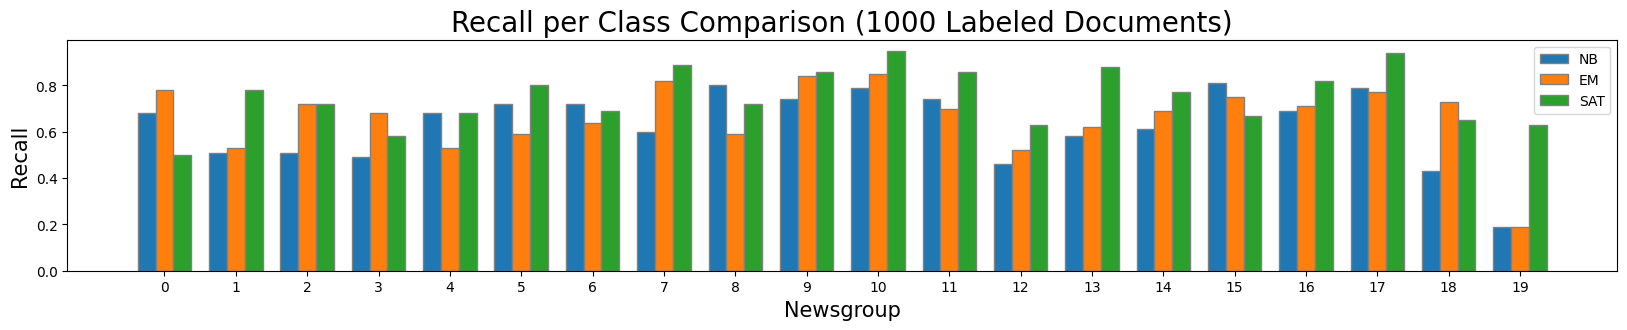

In [37]:
## Plot Recall All
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 3))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, NB_rec, color ='tab:blue', width = barWidth,
        edgecolor = 'grey', label ='NB')
plt.bar(br2, total_rec[1,:], color ='tab:orange', width = barWidth,
        edgecolor ='grey', label ='EM')
plt.bar(br3, SAT_rec_mat[1,:], color ='tab:green', width = barWidth,
        edgecolor ='grey', label ='SAT')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('Recall', fontsize = 15)
plt.title('Recall per Class Comparison (1000 Labeled Documents)',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()

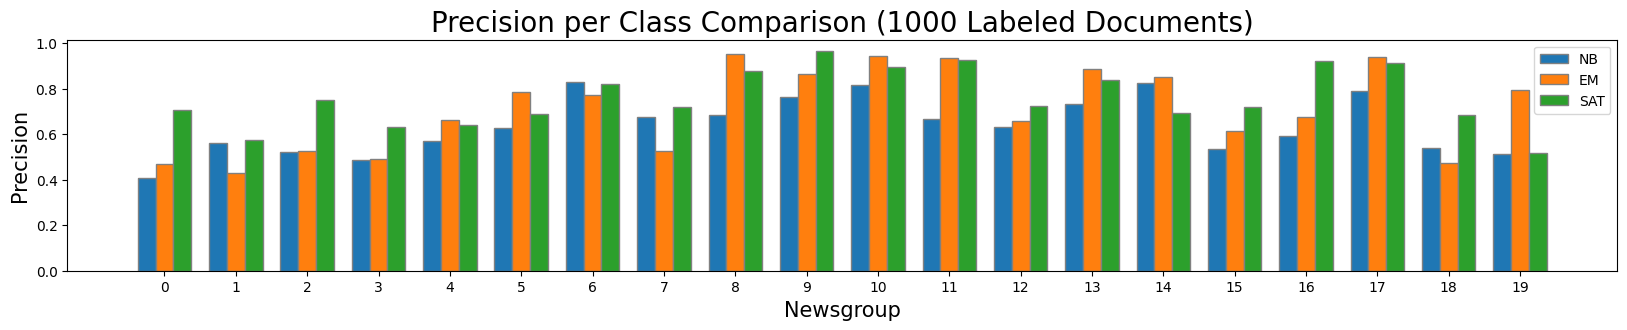

In [39]:
## Plot Precision All
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 3))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, NB_prec, color ='tab:blue', width = barWidth,
        edgecolor = 'grey', label ='NB')
plt.bar(br2, total_prec[1,:], color ='tab:orange', width = barWidth,
        edgecolor ='grey', label ='EM')
plt.bar(br3, SAT_prec_mat[1,:], color ='tab:green', width = barWidth,
        edgecolor ='grey', label ='SAT')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.title('Precision per Class Comparison (1000 Labeled Documents)',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()

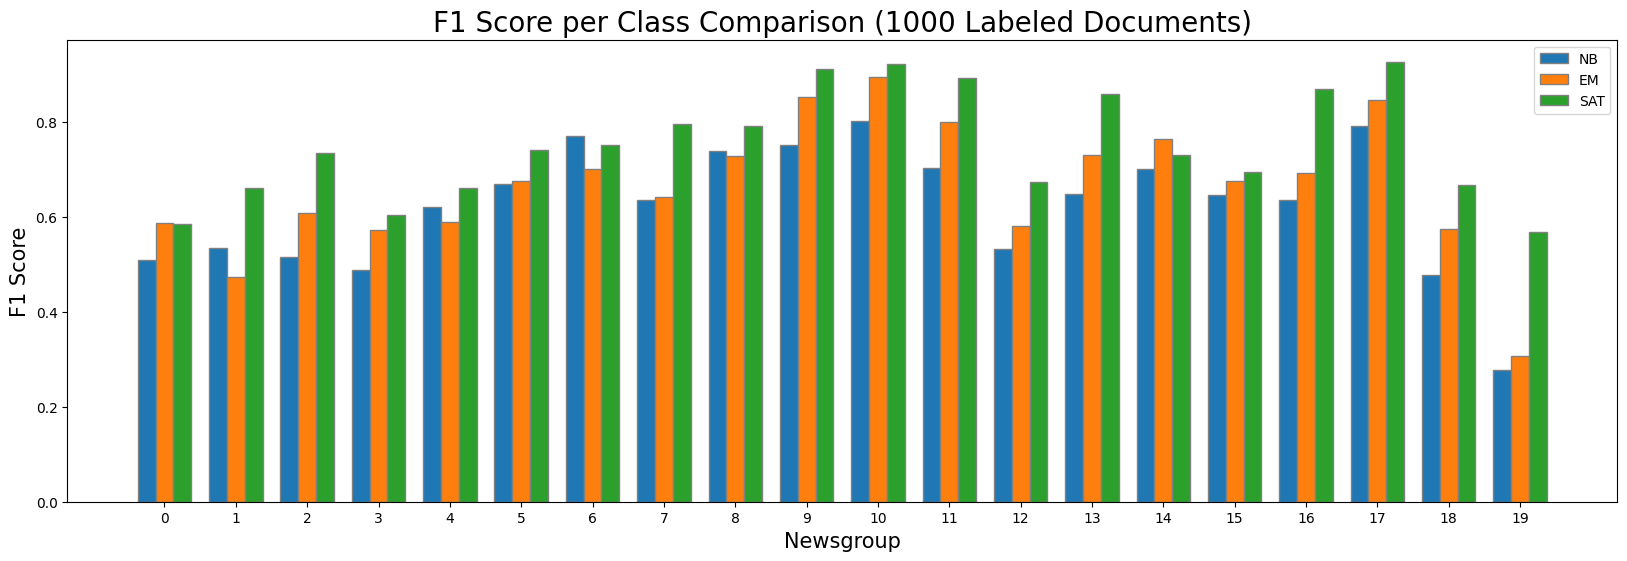

In [44]:
## Plot F1 All
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))

# Set position of bar on X axis
br1 = np.arange(20)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, NB_f1, color ='tab:blue', width = barWidth,
        edgecolor = 'grey', label ='NB')
plt.bar(br2, EM_f1[1,:], color ='tab:orange', width = barWidth,
        edgecolor ='grey', label ='EM')
plt.bar(br3, SAT_f1[1,:], color ='tab:green', width = barWidth,
        edgecolor ='grey', label ='SAT')


# Adding Xticks
plt.xlabel('Newsgroup', fontsize = 15)
plt.ylabel('F1 Score', fontsize = 15)
plt.title('F1 Score per Class Comparison (1000 Labeled Documents)',fontsize = 20)
plt.xticks([r + barWidth for r in range(20)],
        np.array(range(20)))

plt.legend()
plt.show()